## Bots and Gender Profiling
https://pan.webis.de/clef19/pan19-web/author-profiling.html

### feature engineering

In [23]:
import random
import sys
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from scipy import stats
from sentence_transformers import SentenceTransformer
from spacy.lang.en import English
from tqdm import tqdm

from dataset import Dataset

In [2]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
dataset = Dataset(Path("/home/ianic/tar/pan19-author-profiling-training-2019-02-18/en"),
                  Path(
                      "/home/ianic/tar/pan19-author-profiling-training-2019-02-18/en_labels/truth.txt"),
                  Path("/home/ianic/tar/pan19-author-profiling-test-2019-04-29/en"),
                  Path("/home/ianic/tar/pan19-author-profiling-test-2019-04-29/truth.txt"))

xtrain, ytrain, xtest, ytest = dataset.get_data()
print(len(xtrain), len(ytrain))
print(len(xtest), len(ytest))

train_data, train_labels, test_data, test_labels = xtrain, ytrain, xtest, ytest

4120 4120
2640 2640


In [5]:
# rule based senencizer works better on our twitter data than the dependency parser based sentence segmentizer
nlp = English()  # just the language with no model
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)
bot_count = 0
human_count = 0
tweet_embeddings = defaultdict(list)

for account in tqdm(data):
    ################## uncomment code to take only N humans and N bots (N=30 here) ###################
    # account = random.choice(list(train_data.keys()))
    # if bot_count == 30 and human_count == 30: break
    # if bot_count == 30 and train_labels[account][0] == "bot": continue
    # if human_count == 30 and train_labels[account][0] == "human": continue
    # if train_labels[account][0] == "bot" and bot_count < 30: print("bot"); bot_count += 1
    # if train_labels[account][0] == "human" and human_count < 30: print("human"); human_count += 1

    tweets = train_data[account]
    for i, tweet in enumerate(tweets):
        doc = nlp(tweet)
        sentences = [str(sentence) for sentence in doc.sents]
        sentence_embeddings = model.encode(sentences)
        tweet_embed = 0
        for j in range(len(sentence_embeddings)):
            tweet_embed += sentence_embeddings[j] / len(sentence_embeddings)
        tweet_embeddings[account].append(tweet_embed)

100%|██████████| 4120/4120 [1:25:29<00:00,  1.24s/it]  


In [6]:
print(len(tweet_embeddings))
print(len(tweet_embeddings['91786c019a86cba323bb437d80d1c745']))
print(len(tweet_embeddings['91786c019a86cba323bb437d80d1c745'][0]))

4120
100
768


In [7]:
# estimate mean and variances per account, calculate mean variances (per feature) for bots and humans, and compare bot and human mean variance
keys_list = list(tweet_embeddings.keys())
bots_keys = [key for key in keys_list if train_labels[key][0] == "bot"]
humans_keys = [key for key in keys_list if train_labels[key][0] == "human"]
print(len(bots_keys), len(humans_keys))

bots_diags = []
for bot in bots_keys:
    bot_data = np.array(tweet_embeddings[bot]).reshape(100, 768)
    mean_bot = np.mean(bot_data, axis=0)
    cov_bot = (bot_data - mean_bot).T @ (bot_data -
                                         mean_bot) / (bot_data.shape[0] - 1)
    bot_diag = cov_bot.diagonal()
    bots_diags.append(bot_diag)

humans_diags = []
for human in humans_keys:
    human_data = np.array(tweet_embeddings[human]).reshape(100, 768)
    mean_human = np.mean(human_data, axis=0)
    cov_human = (human_data - mean_human).T @ (human_data -
                                               mean_human) / (human_data.shape[0] - 1)
    human_diag = cov_human.diagonal()
    humans_diags.append(human_diag)

humans_diags = np.array(humans_diags)
bots_diags = np.array(bots_diags)
mean_bots_diag = np.mean(bots_diags, axis=0)
mean_humans_diag = np.mean(humans_diags, axis=0)

d = {'humans_diags': humans_diags,
     'mean_bots_diag': mean_bots_diag,
     'mean_humans_diag': mean_humans_diag
     }

print(
    f"HUMANS MEAN DIAG VARIANCE GREATER THAN BOTS MEAN DIAG VARIANCE FOR: {mean_humans_diag[mean_humans_diag > mean_bots_diag].shape[0]} dims")
print(f"BOTS MEAN of MEAN DIAG VARIANCE {np.mean(mean_bots_diag)}")
print(f"HUMANS MEAN of MEAN DIAG VARIANCE {np.mean(mean_humans_diag)}")

2060 2060
HUMANS MEAN DIAG VARIANCE GREATER THAN BOTS MEAN DIAG VARIANCE FOR: 742 dims
BOTS MEAN of MEAN DIAG VARIANCE 0.12392880767583847
HUMANS MEAN of MEAN DIAG VARIANCE 0.14262627065181732


In [8]:
bots_diags.shape

(2060, 768)

In [45]:
print(len(humans_diags))
print(len(mean_humans_diag))
print(len(mean_bots_diag))

2060
768
768


In [ ]:
df = pd.DataFrame(d, columns=['mean_bots_diag', 'mean_humans_diag'])
df.to_pickle("./pan19_df_sent_embed_var_means.pkl")

In [13]:
diff = mean_humans_diag - mean_bots_diag
df_diff = pd.DataFrame(diff, columns=['mean_diff_diag'])

In [11]:
df = pd.DataFrame(d, columns=['mean_bots_diag', 'mean_humans_diag'])
df

,mean_bots_diag,mean_humans_diag
0,0.086717,0.101449
1,0.122629,0.148658
2,0.264287,0.340731
3,0.051987,0.054089
4,0.093740,0.110424
...,...,...
763,0.095327,0.092374
764,0.071874,0.072882
765,0.133723,0.138461
766,0.148922,0.154934


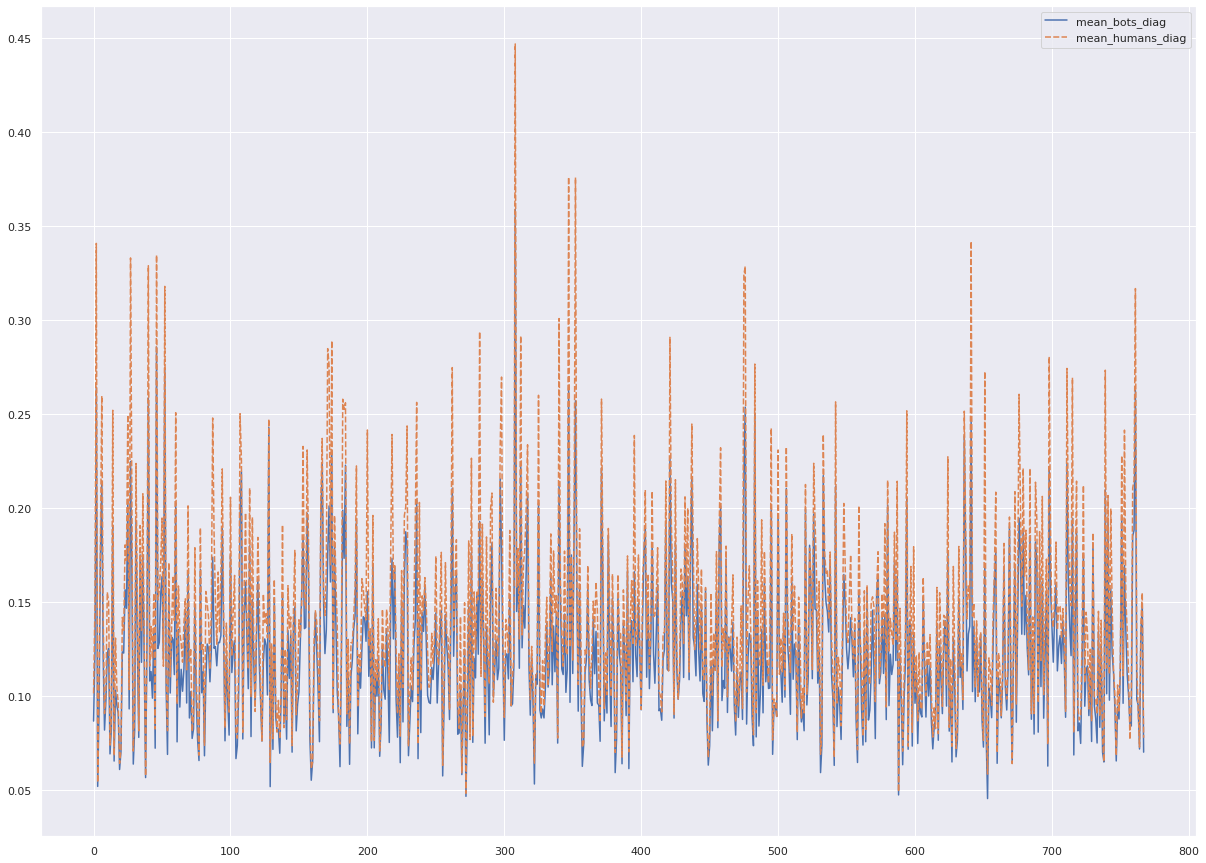

In [12]:
sns.set(rc={'figure.figsize':(20.7,15.27)})
sns.lineplot(data=df, ci='sd')

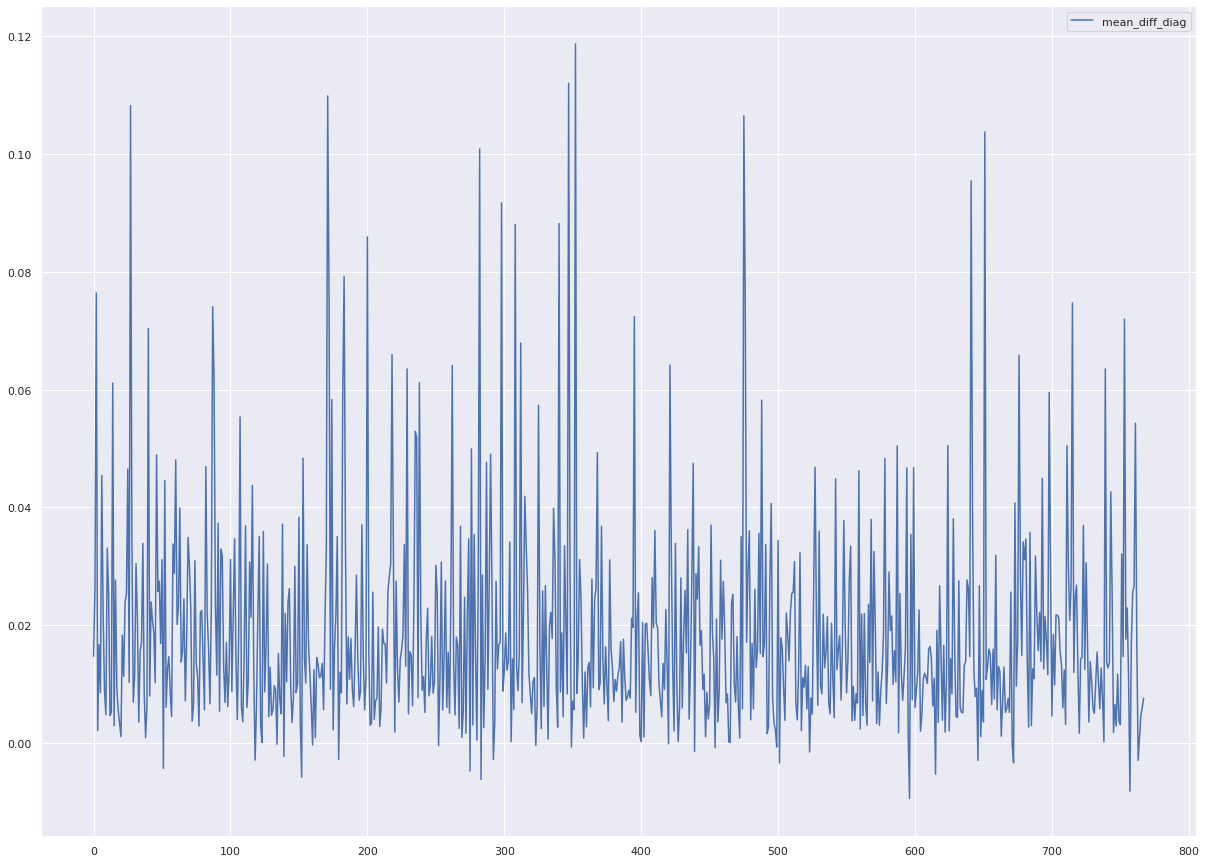

In [14]:
sns.set(rc={'figure.figsize':(20.7,15.27)})
sns.lineplot(data=df_diff, ci='sd')

In [22]:
print(f"HUMANS MEAN DIAG VARIANCE GREATER THAN BOTS MEAN DIAG VARIANCE FOR: {mean_humans_diag[mean_humans_diag > mean_bots_diag].shape[0]} dims")
print(f"BOTS MEAN of MEAN DIAG VARIANCE {np.mean(mean_bots_diag)}")
print(f"HUMANS MEAN of MEAN DIAG VARIANCE {np.mean(mean_humans_diag)}")

HUMANS MEAN DIAG VARIANCE GREATER THAN BOTS MEAN DIAG VARIANCE FOR: 749 dims
BOTS MEAN of MEAN DIAG VARIANCE 0.12222407013177872
HUMANS MEAN of MEAN DIAG VARIANCE 0.1433313637971878


In [34]:
bots_datas = []
for bot in bots_keys:
    bots_datas.append(np.array(tweet_embeddings[bot]).reshape(100, 768))

humans_datas = []
for human in humans_keys:
    humans_datas.append(np.array(tweet_embeddings[human]).reshape(100, 768))

print (np.array(bots_datas).shape)

(2060, 100, 768)


In [42]:
stat, p = stats.ttest_ind(np.array(bots_datas).reshape(206000, 768), 
                          np.array(humans_datas).reshape(206000, 768), axis=0)

### Significantly different dimensions
to avoid false positives, we use [bonferroni correction](https://mathworld.wolfram.com/BonferroniCorrection.html)

In [51]:
# https://mathworld.wolfram.com/BonferroniCorrection.html
len(p[np.where(p < 0.05/768)])

730

We can conclude that, for 730 out of 768 dimensions, human tweet embeddings significantly differ from those of bots at a significance level of .05.